In [2]:
import os
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers 
from tensorflow.keras import models
import random
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

## Load the data

To avoid issues due to confusion between numerical and non-numerical data, the file `Raw_Phys_Descrip.txt` consists of all the numerical physical descriptors (i.e. all the variables except `Config`). The correponding entry of `Config` are directly define in the cell below.    

In [16]:
PhyD_Names = ['N', 'infa_C_Au', 'infa_S_Mg', 'infa_S_O', 'cc', 'cs_Mg', 'cs_O', 
             'ave_GCN', 'csDist_Mg', 'csDist_O', 'Zdist', 'Ecoh', 'Eadh', 'Eb', 'Etot']
X_vars = ['N', 'infa_C_Au', 'infa_S_Mg', 'infa_S_O', 'cc', 'cs_Mg', 'cs_O', 
             'ave_GCN', 'csDist_Mg', 'csDist_O', 'Zdist', 'Eb']

PhyD = pd.DataFrame(np.loadtxt('Data/Raw_Phys_Descrip.txt', delimiter=',', dtype=float), columns=PhyD_Names)

Config = np.concatenate((np.repeat('1Au',104), np.repeat('2Au',104), np.repeat('3Au',105), 
                         np.repeat('4Au_a',102), np.repeat('4Au_b',45), np.repeat('4Au_c',103), 
                         np.repeat('4Au_d',104), np.repeat('4Au_e',105), np.repeat('4Au_f',96), 
                         np.repeat('5Au_a',103), np.repeat('5Au_b',103), np.repeat('5Au_c',103),
                         np.repeat('5Au_d',104), np.repeat('5AU_e',102),
                         np.repeat('6Au_a',105), np.repeat('6Au_b',105), 
                         np.repeat('9Au_a',99), np.repeat('9Au_b',79), 
                         np.repeat('12Au_a',12), 
                         np.repeat('24Au_b',56)))

Cl_XYZ = pd.DataFrame.to_numpy(pd.read_csv('Data/Cluster_XYZ.csv', header=None, names=range(3*24)))
FingerPrints = pd.read_csv('Data/StruFg.csv')
Nobs = PhyD.shape[0]

In [11]:
PhyD.shape, Cl_XYZ.shape, FingerPrints.shape

((1839, 15), (1839, 72), (1839, 15))

In [25]:
X = pd.concat([PhyD[X_vars], FingerPrints], axis=1).to_numpy()
y = PhyD['Etot'].to_numpy()

In [26]:
scaler1 = preprocessing.StandardScaler().fit(X) 
X_scaled = scaler1.transform(X)
y_scaled = (y - np.mean(y))/np.std(y)

In [56]:
reset_random_seeds()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [57]:
reset_random_seeds() # reset the random seed

ANN_1 = models.Sequential()
ANN_1.add(layers.Dense(360, activation='relu', input_shape=(27,)))

#ANN_4Au_X1.add(layers.Dense(360, input_shape=(12,), activation='relu', kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01)))
#ANN_4Au_X1.add(Dropout(0.2))

ANN_1.add(layers.Dense(360, activation='relu'))

ANN_1.add(layers.Dense(180, activation='relu'))

ANN_1.add(layers.Dense(90, activation='relu'))

ANN_1.add(layers.Dense(1, activation='linear'))

In [58]:
ANN_1.compile(optimizer='adagrad',
                   loss='mse',
                   metrics=['mean_squared_error'])

In [ ]:
history_1 = ANN_1.fit(X_train, y_train, 
                                validation_data=(X_val, y_val), 
                                epochs=300, batch_size=100,
                                verbose=0)

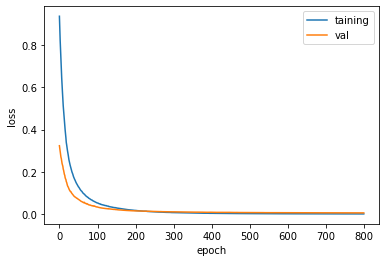

In [54]:
plt.plot(history_1.history['loss'], label='taining')
plt.plot(history_1.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

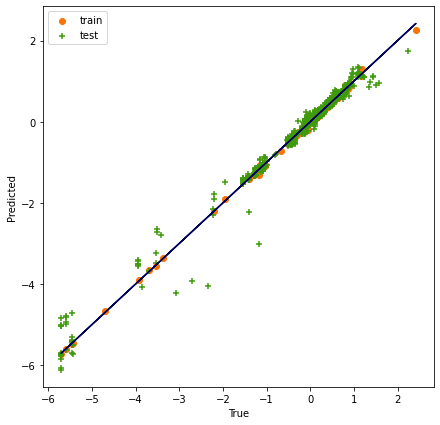

In [55]:
pred_test = ANN_1.predict(X_test)
pred_train = ANN_1.predict(X_train)

plt.figure(figsize=(7, 7))

plt.scatter(y_train, pred_train, marker="o",color='#f97306',label='train')
plt.scatter(y_test, pred_test, marker="+",color='#3f9b0b',label='test')
plt.legend(loc='upper left')
plt.plot(y_train, y_train,color='#00035b')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.show()